In [136]:
!pip install tqdm
!pip install lightgbm
!pip install tensorflow scikit-learn


In [137]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.utils import parallel_backend
import lightgbm as lgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [138]:
base_dir = os.path.expanduser("~/Desktop/Kaggle dataset/playground-series_2025")
train_data = pd.read_csv(os.path.join(base_dir, "train.csv"))
test_data = pd.read_csv(os.path.join(base_dir, "test.csv"))

In [139]:
print("training data:\n")
print(f"shape:{train_data.shape}\n")
print(train_data.dtypes)
print("\ntesting data:\n")
print(f"shape:{test_data.shape}\n")
print(test_data.dtypes)

training data:

shape:(750000, 12)

id                               int64
Podcast_Name                    object
Episode_Title                   object
Episode_Length_minutes         float64
Genre                           object
Host_Popularity_percentage     float64
Publication_Day                 object
Publication_Time                object
Guest_Popularity_percentage    float64
Number_of_Ads                  float64
Episode_Sentiment               object
Listening_Time_minutes         float64
dtype: object

testing data:

shape:(250000, 11)

id                               int64
Podcast_Name                    object
Episode_Title                   object
Episode_Length_minutes         float64
Genre                           object
Host_Popularity_percentage     float64
Publication_Day                 object
Publication_Time                object
Guest_Popularity_percentage    float64
Number_of_Ads                  float64
Episode_Sentiment               object
dtype: object


In [140]:
train_df = train_data.copy()
test_df = test_data.copy()

In [141]:
train_df.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [142]:
test_df.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,750000,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,750001,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
2,750002,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,750003,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,750004,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral


In [143]:
train_df = train_df.drop(columns=["Podcast_Name"])
test_df = test_df.drop(columns=["Podcast_Name"])
qualitative_vars = ['Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']

for col in qualitative_vars:
    # Train 設成 category 並保留原始類別
    train_df[col] = train_df[col].astype("category")
    
    # Test 用 train 的類別定義建立 category，再強制設 dtype
    test_df[col] = pd.Categorical(test_df[col], categories=train_df[col].cat.categories)
    test_df[col] = test_df[col].astype("category")

    # 一起轉成整數編碼（保持一致）
    train_df[col] = train_df[col].cat.codes
    test_df[col] = test_df[col].cat.codes


In [144]:
train_df["Episode_Title"] = train_df["Episode_Title"].str.extract(r"(\d+)").astype(int)
test_df["Episode_Title"] = test_df["Episode_Title"].str.extract(r"(\d+)").astype(int)

In [145]:
train_df.describe()

,id,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
count,750000.000000,750000.000000,662907.000000,750000.000000,750000.000000,750000.000000,750000.000000,603970.000000,749999.000000,750000.000000,750000.000000
mean,374999.500000,51.445811,64.504738,4.648788,59.859901,2.962776,1.522868,52.236449,1.348855,0.997969,45.437406
std,216506.495284,28.085623,32.969603,2.963073,22.873098,1.997399,1.119361,28.451241,1.151130,0.815440,27.138306
min,0.000000,1.000000,0.000000,0.000000,1.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,187499.750000,28.000000,35.730000,2.000000,39.410000,1.000000,1.000000,28.380000,0.000000,0.000000,23.178350
50%,374999.500000,52.000000,63.840000,5.000000,60.050000,3.000000,1.000000,53.580000,1.000000,1.000000,43.379460
75%,562499.250000,75.000000,94.070000,7.000000,79.530000,5.000000,3.000000,76.600000,2.000000,2.000000,64.811580
max,749999.000000,100.000000,325.240000,9.000000,119.460000,6.000000,3.000000,119.910000,103.910000,2.000000,119.970000


有缺失值的變數：`Episode_Length_minutes`, `Guest_Popularity_percentage`, `Number_of_Ads`

In [146]:
Q1 = train_df["Episode_Length_minutes"].quantile(0.25)
Q3 = train_df["Episode_Length_minutes"].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

train_df = train_df[
    (train_df["Episode_Length_minutes"] >= lower) &
    (train_df["Episode_Length_minutes"] <= upper)
]

median_val = train_df["Episode_Length_minutes"].median()
train_df["Episode_Length_minutes"] = train_df["Episode_Length_minutes"].fillna(median_val)

print("總筆數：", len(train_df))
print("剩餘缺失值：", train_df["Episode_Length_minutes"].isnull().sum())

總筆數： 662906
剩餘缺失值： 0


In [147]:
median_test = test_df["Episode_Length_minutes"].median()
test_df["Episode_Length_minutes"] = test_df["Episode_Length_minutes"].fillna(median_test)

print("總筆數：", len(test_df))
print("剩餘缺失值：", test_df["Episode_Length_minutes"].isnull().sum())


總筆數： 250000
剩餘缺失值： 0


In [161]:
Q1 = train_df["Number_of_Ads"].quantile(0.25)
Q3 = train_df["Number_of_Ads"].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

train_df = train_df[
    (train_df["Number_of_Ads"] >= lower) &
    (train_df["Number_of_Ads"] <= upper)
]

median_ads = train_df["Number_of_Ads"].median()
train_df["Number_of_Ads"] = train_df["Number_of_Ads"].fillna(median_ads)
train_df["Number_of_Ads"] = train_df["Number_of_Ads"].astype(int)
print("總筆數：", len(train_df))
print("剩餘缺失值：", train_df["Number_of_Ads"].isnull().sum())


總筆數： 662896
剩餘缺失值： 0


In [ ]:
test_df.loc[test_df["Number_of_Ads"] > 10, "Number_of_Ads"] = 10
median_ads = test_df["Number_of_Ads"].median()
test_df["Number_of_Ads"] = test_df["Number_of_Ads"].fillna(median_ads)
test_df["Number_of_Ads"] = test_df["Number_of_Ads"].astype(int)

## Correlation matrix

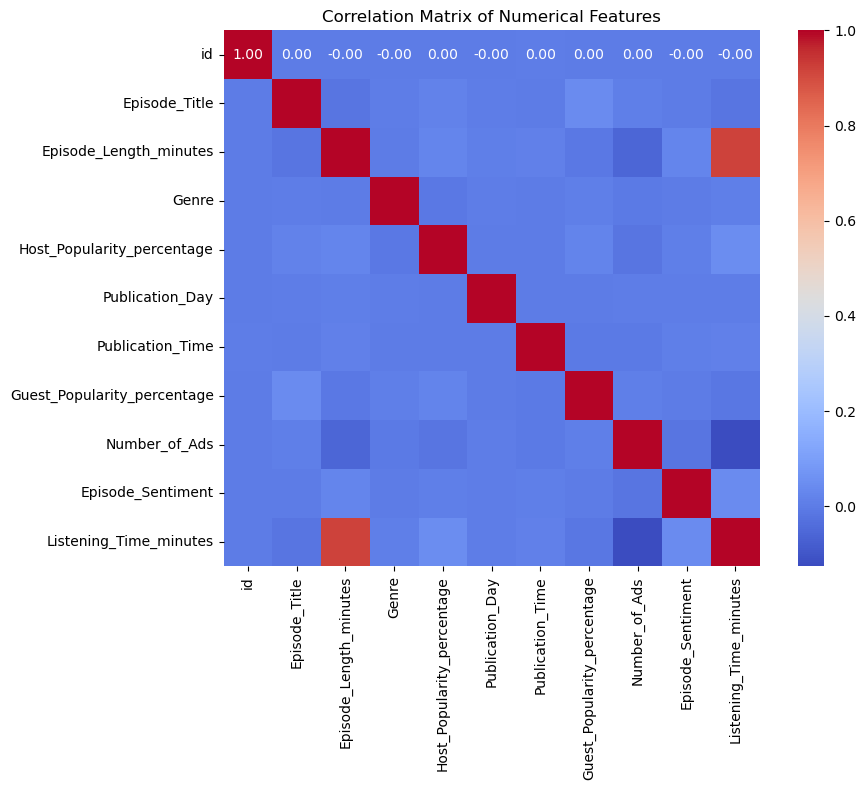

In [150]:
correlation_matrix = train_df.corr(numeric_only=True)

# 畫出熱圖
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.show()

In [163]:
Q1 = train_df["Guest_Popularity_percentage"].quantile(0.25)
Q3 = train_df["Guest_Popularity_percentage"].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

train_df["Guest_Popularity_percentage"] = train_df["Guest_Popularity_percentage"].clip(lower, upper)
train_df["Guest_Popularity_percentage"].fillna(train_df["Guest_Popularity_percentage"].median(), inplace=True)

print("總筆數：", len(train_df))
print("剩餘缺失值：", train_df["Guest_Popularity_percentage"].isnull().sum())

總筆數： 662896
剩餘缺失值： 0


In [165]:
test_df["Guest_Popularity_percentage"].fillna(test_df["Guest_Popularity_percentage"].median(), inplace=True)

print("總筆數：", len(test_df))
print("剩餘缺失值：", test_df["Guest_Popularity_percentage"].isnull().sum())

總筆數： 250000
剩餘缺失值： 0


In [168]:
train_df.head()

,id,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
1,1,26,119.80,1,66.95,2,0,75.95,2,0,88.01241
2,2,16,73.90,2,69.97,5,1,8.97,0,0,44.92531
3,3,45,67.17,8,57.22,1,2,78.70,2,2,46.27824
4,4,86,110.51,3,80.07,1,0,58.68,3,1,75.61031
5,5,19,26.54,3,48.96,2,0,53.63,3,2,22.77047


In [167]:
test_df.head()

,id,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,750000,73,78.96,2,38.11,2,1,53.33,1,1
1,750001,23,27.87,5,71.29,3,2,53.36,0,1
2,750002,11,69.10,1,67.89,0,1,97.51,0,2
3,750003,73,115.39,1,23.40,3,2,51.75,2,2
4,750004,50,72.32,4,58.10,6,2,11.30,2,1


## Prediction

In [169]:
X = train_df.drop(columns=["id", "Listening_Time_minutes"])
y = train_df["Listening_Time_minutes"]
# 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression

In [170]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_valid)

### LightGBM

In [171]:
lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_valid)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 530316, number of used features: 9
[LightGBM] [Info] Start training from score 45.732276


In [172]:
def evaluate_model(y_true, y_pred):
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))


In [173]:
# 組成 DataFrame
results_df = pd.DataFrame({
    "Actual": y_valid,
    "LR_Pred": y_pred_lr,
    "LGB_Pred": y_pred_lgb
})

# 計算 RMSE
rmse_lr = np.sqrt(mean_squared_error(results_df["Actual"], results_df["LR_Pred"]))
rmse_lgb = np.sqrt(mean_squared_error(results_df["Actual"], results_df["LGB_Pred"]))

print(rmse_lr)
print(rmse_lgb)


10.681350467017547
10.4035506120277


### Neural Network

In [177]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU

nn_model = Sequential([
    Dense(256), BatchNormalization(), LeakyReLU(), Dropout(0.3),
    Dense(128), BatchNormalization(), LeakyReLU(), Dropout(0.2),
    Dense(64), LeakyReLU(),
    Dense(32), LeakyReLU(),
    Dense(16), LeakyReLU(),
    Dense(1)
])
nn_model.compile(optimizer='adam', loss='mse')
nn_model.fit(X_train, y_train, epochs=20, batch_size=2048, validation_data=(X_valid, y_valid), verbose=0)

# 預測與 RMSE 評估
y_pred_nn = nn_model.predict(X_valid).flatten()
rmse_nn = np.sqrt(mean_squared_error(y_valid, y_pred_nn))
print(f"Neural Network RMSE: {rmse_nn}")

In [180]:
# 把所有 RMSE 放進字典
rmse_dict = {
    "LightGBM": rmse_lgb,
    "LinearRegression": rmse_lr,
    "NeuralNet": rmse_nn
}

# 找出最小 RMSE 對應的模型名稱
best_model_name = min(rmse_dict, key=rmse_dict.get)
print(f"最佳模型是：{best_model_name}, RMSE = {rmse_dict[best_model_name]:.4f}")

# 根據名字選出對應的模型物件
if best_model_name == "LightGBM":
    model = lgb_model
elif best_model_name == "LinearRegression":
    model = lr_model
else:
    model = nn_model 

最佳模型是：LightGBM, RMSE = 10.4036


In [181]:
y_test_pred = model.predict(test_df.drop(columns=["id"]))

# 如果你有 ID 欄位，可以合併回預測結果
output_df = pd.DataFrame({
    "id": test_df['id'],  # 或 test_df["id"] 如果有明確 id 欄
    "Listening_Time_minutes": y_test_pred
})

# 檢查前幾筆
print(output_df.head())

       id  Listening_Time_minutes
0  750000               55.594467
1  750001               18.129104
2  750002               50.084595
3  750003               81.874520
4  750004               48.602416


In [182]:
output_df.to_csv("submission.csv", index=False)